In [ ]:
!pip install --upgrade pip > /dev/null
!pip install seaborn > /dev/null
!pip install torch > /dev/null

In [3]:
import os
import glob
import time
import datetime
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import random
np.random.seed(42)
random.seed(42)

import plotly.graph_objects as go
import plotly.express as px

import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
from generate_anomaly_score import generate_anomaly_score, process_and_save_anomaly_scores
from LSTMAutoencoder import SimpleLSTMAutoencoder

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


cuda


# Load Data

In [4]:
# load training data
df_p1 = pd.read_csv('./data/full_data_plant1.csv', index_col = 'timestamp')
# df_p1['active_power_u1'] = df_p1['active_power_u1'].apply(lambda i: 0 if i < 1 else i)
# df_p1['active_power_u2'] = df_p1['active_power_u2'].apply(lambda i: 0 if i < 1 else i)
df_p1['oil_pump_u1'] = df_p1[['oil_pump1_u1', 'oil_pump2_u1']].max(axis=1)
df_p1['oil_pump_u2'] = df_p1[['oil_pump1_u2', 'oil_pump2_u2']].max(axis=1)
df_p1

,active_power_u1,oil_pressure_u1,oil_pump1_u1,oil_pump2_u1,active_power_u2,oil_pressure_u2,oil_pump1_u2,oil_pump2_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,,,,,
2023-02-01 00:00:00,20.700001,149.699997,1.0,0.0,22.900000,146.699997,0.0,1.0,1.0,1.0
2023-02-01 00:01:00,20.700001,149.449997,1.0,0.0,22.950000,146.700000,0.0,1.0,1.0,1.0
2023-02-01 00:02:00,20.700001,149.447365,1.0,0.0,22.900000,146.707144,0.0,1.0,1.0,1.0
2023-02-01 00:03:00,20.700001,149.457140,1.0,0.0,22.900000,146.683334,0.0,1.0,1.0,1.0
2023-02-01 00:04:00,20.700001,149.511112,1.0,0.0,22.950000,146.705556,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:56:00,3.672727,140.182352,0.0,0.0,2.061765,138.482609,0.0,0.0,0.0,0.0
2024-01-31 23:57:00,3.672727,139.775000,0.0,0.0,2.061765,136.750000,0.0,0.0,0.0,0.0
2024-01-31 23:58:00,3.672727,139.507693,0.0,0.0,2.061765,135.350000,0.0,0.0,0.0,0.0


In [5]:
df_p2= pd.read_csv('./data/full_data_plant2.csv', index_col = 'timestamp')
df_p2['oil_pump_u1'] = df_p2[['oil_pump1_u1', 'oil_pump2_u1']].max(axis=1)
df_p2['oil_pump_u2'] = df_p2[['oil_pump1_u2', 'oil_pump2_u2']].max(axis=1)
df_p2

,active_power_u1,oil_pressure_u1,oil_pump1_u1,oil_pump2_u1,active_power_u2,oil_pressure_u2,oil_pump1_u2,oil_pump2_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,,,,,
2023-02-01 00:00:00,37.169407,100.001770,1.0,0.0,10.479582,106.487946,0.0,1.0,1.0,1.0
2023-02-01 00:01:00,36.838044,99.961022,1.0,0.0,15.750134,106.049909,0.0,1.0,1.0,1.0
2023-02-01 00:02:00,36.696438,99.960967,1.0,0.0,16.463206,106.015044,0.0,1.0,1.0,1.0
2023-02-01 00:03:00,36.813082,99.950918,1.0,0.0,14.003401,106.046253,0.0,1.0,1.0,1.0
2023-02-01 00:04:00,37.037916,99.969268,1.0,0.0,14.661157,106.143629,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:56:00,10.571480,97.238802,0.0,0.0,16.231666,106.354586,0.0,0.0,0.0,0.0
2024-01-31 23:57:00,10.571480,96.181768,0.0,0.0,15.154579,106.437179,0.0,0.0,0.0,0.0
2024-01-31 23:58:00,10.571480,96.744238,0.0,0.0,12.345287,106.404465,0.0,0.0,0.0,0.0


In [6]:
timespan_p1_u1_full = ['2023-08-16 08:00:00','2023-09-01 08:00:00']
timespan_p1_u2_full = ['2023-07-04 14:00:00','2023-07-05 14:00:00']
timespan_p1_u2_small = ['2023-06-30 00:00:00','2023-06-30 02:00:00']
timespan_p2_u2_full = ['2023-04-27 01:00:00','2023-04-29 01:00:00']

## Visualize raw data

<Axes: xlabel='timestamp'>

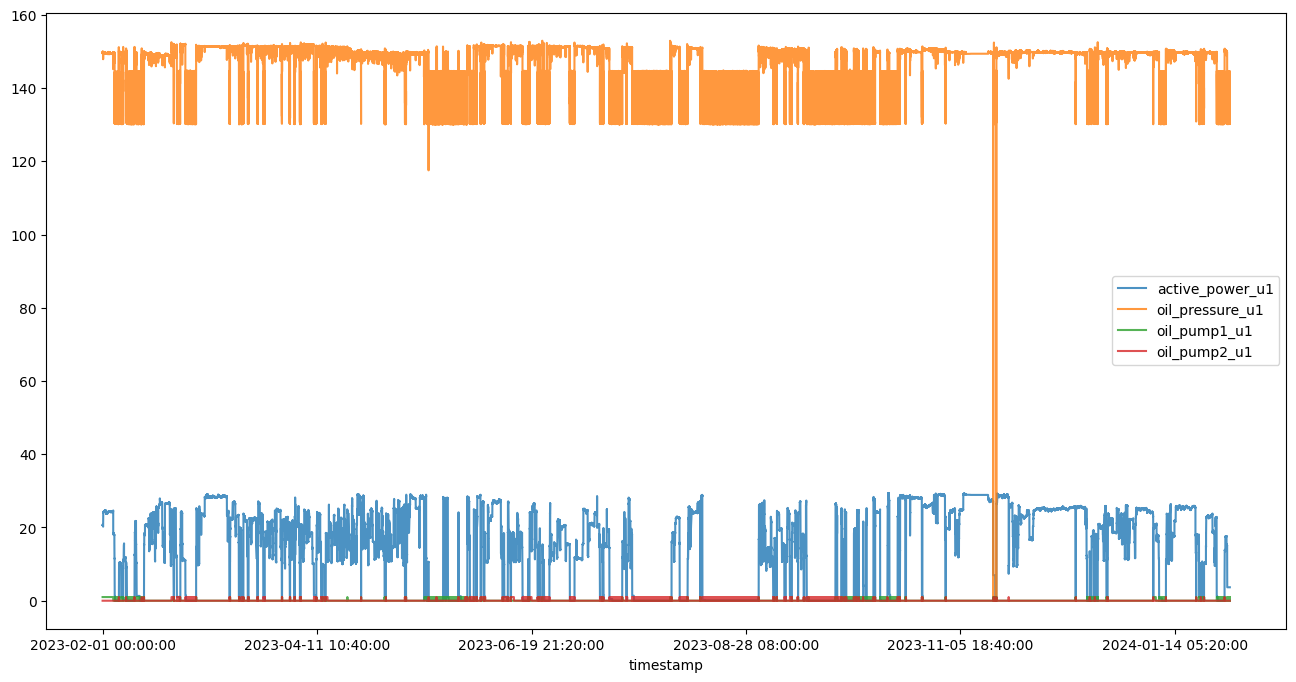

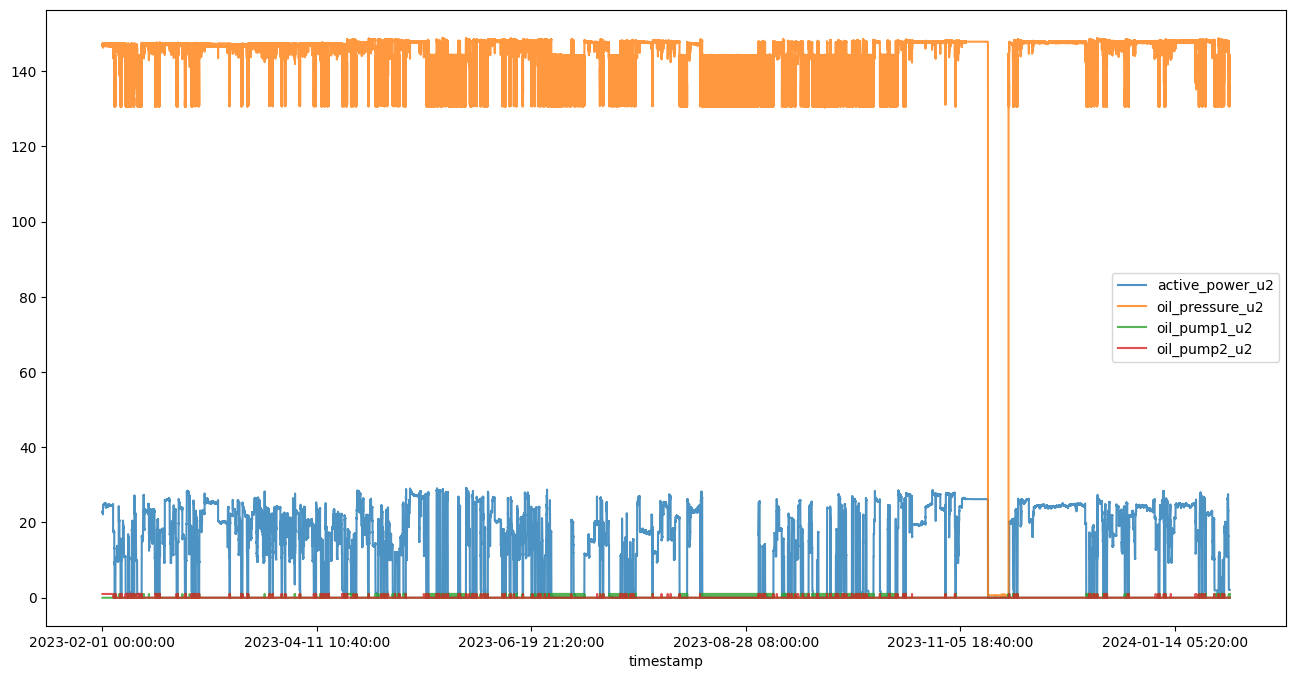

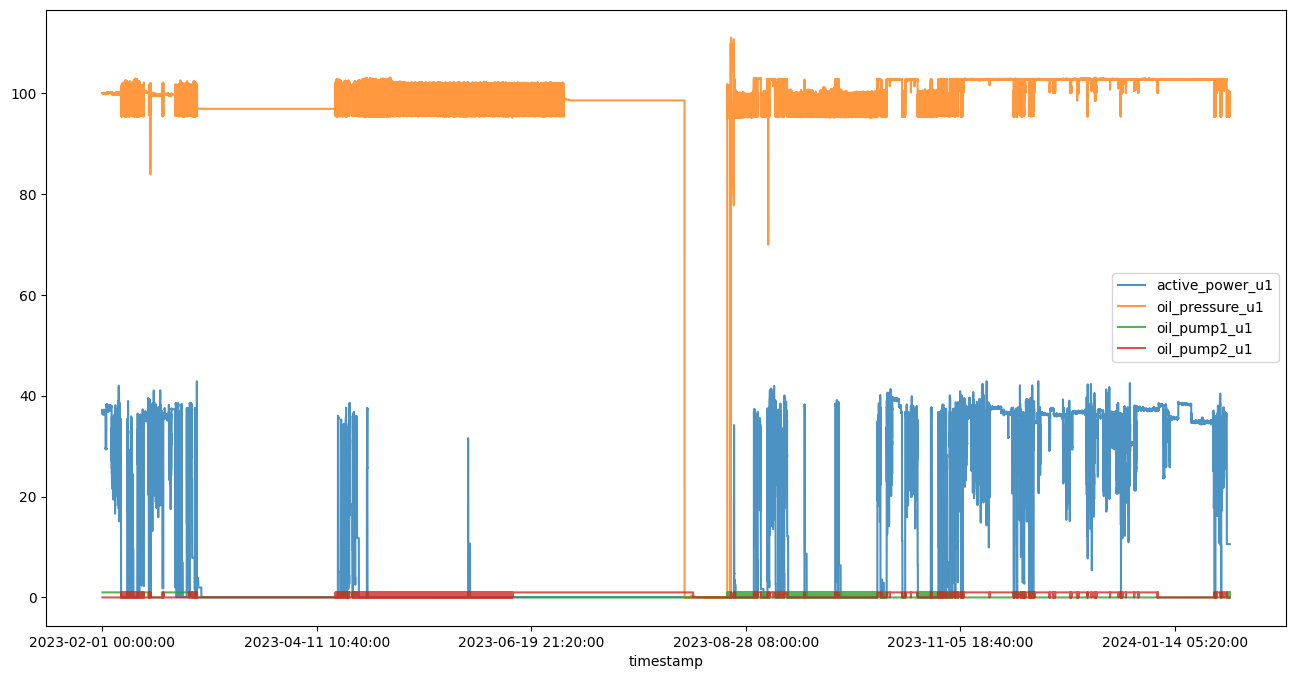

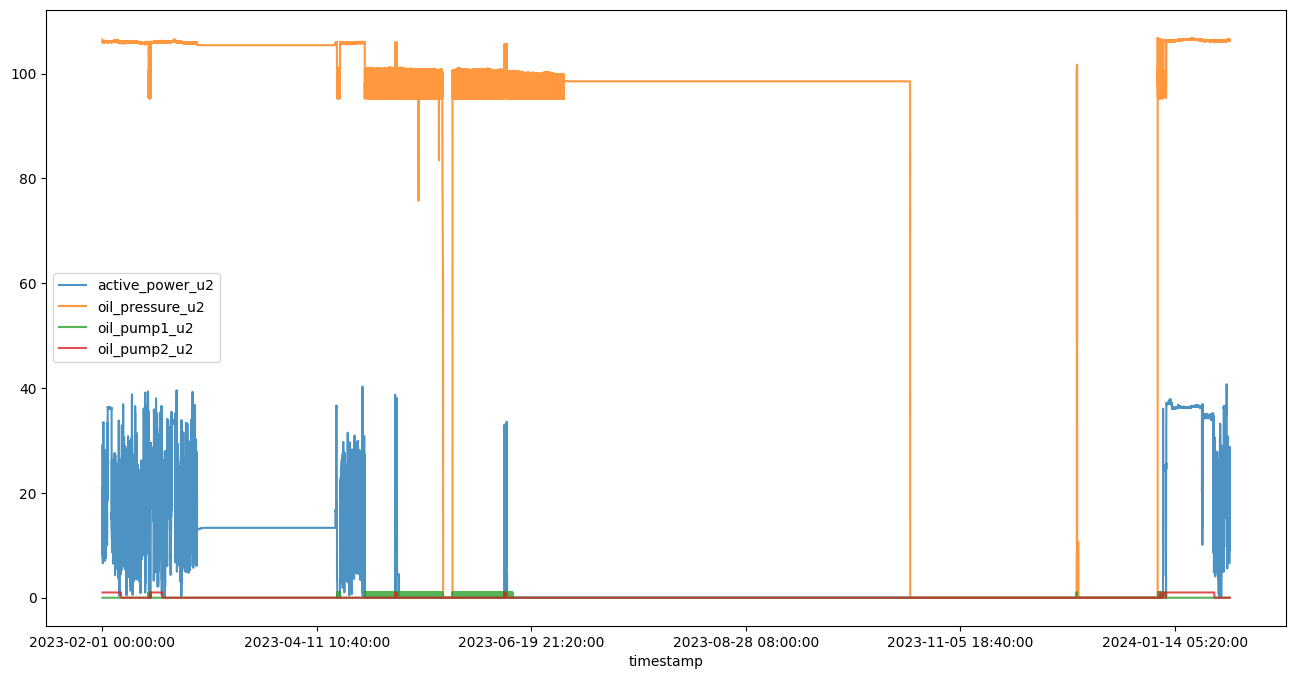

In [7]:
df_p1.iloc[:,:4].plot(figsize=(16,8), alpha=0.8)
df_p1.iloc[:,4:-2].plot(figsize=(16,8), alpha=0.8)

df_p2.iloc[:,:4].plot(figsize=(16,8), alpha=0.8)
df_p2.iloc[:,4:-2].plot(figsize=(16,8), alpha=0.8)

In [8]:
p1_u1_full = df_p1.iloc[:,[0,1,8]].loc[timespan_p1_u1_full[0]:timespan_p1_u1_full[1]]
p1_u2_full = df_p1.iloc[:,[4,5,9]].loc[timespan_p1_u2_full[0]:timespan_p1_u2_full[1]]
p1_u2_small = df_p1.iloc[:,[4,5,9]].loc[timespan_p1_u2_small[0]:timespan_p1_u2_small[1]]
p2_u2_full = df_p2.iloc[:,[4,5,9]].loc[timespan_p2_u2_full[0]:timespan_p2_u2_full[1]]

p1_u1_full.shape, p1_u2_full.shape, p1_u2_small.shape, p2_u2_full.shape

((1441, 3), (1441, 3), (121, 3), (2881, 3))

In [ ]:
# p1_u1_full.iloc[:,:].loc['2023-08-14 08:00:00':'2023-08-14 20:00:00'].to_csv('./data/test_p1_u1.csv')
# p1_u2_small.iloc[:,:].loc['2023-06-30 00:00:00':'2023-06-30 12:00:00'].to_csv('./data/test_p2_u2.csv')
# p2_u2_full.iloc[:,:].loc[timespan_p2_u2_full[0]:'2023-05-03 04:00:00'].to_csv('./data/test_p2_u2.csv')

<Axes: xlabel='timestamp'>

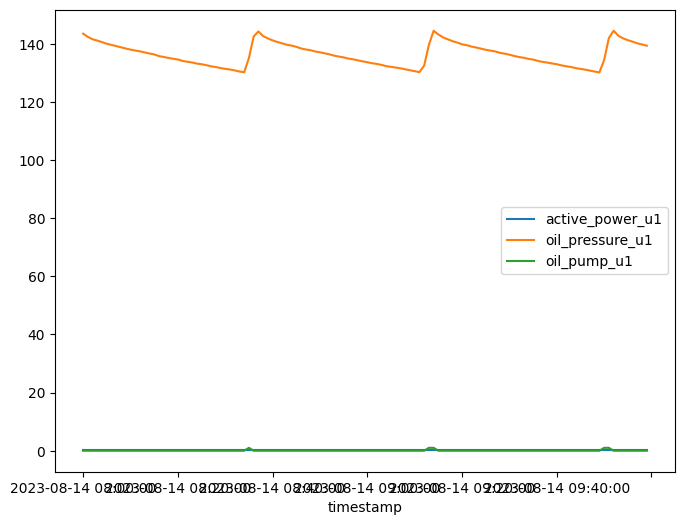

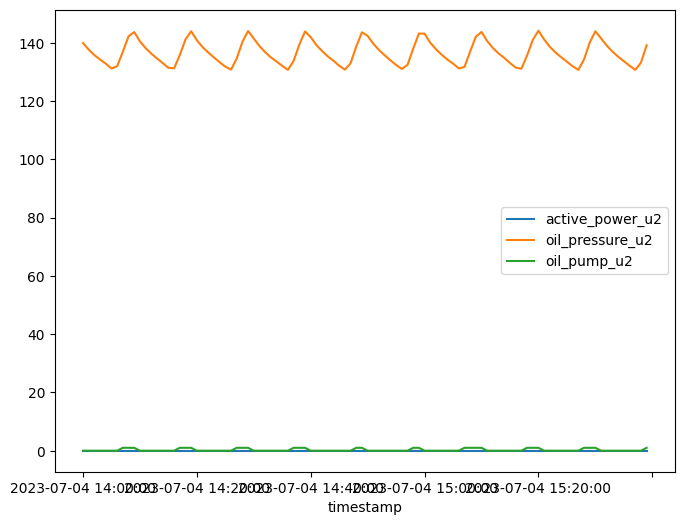

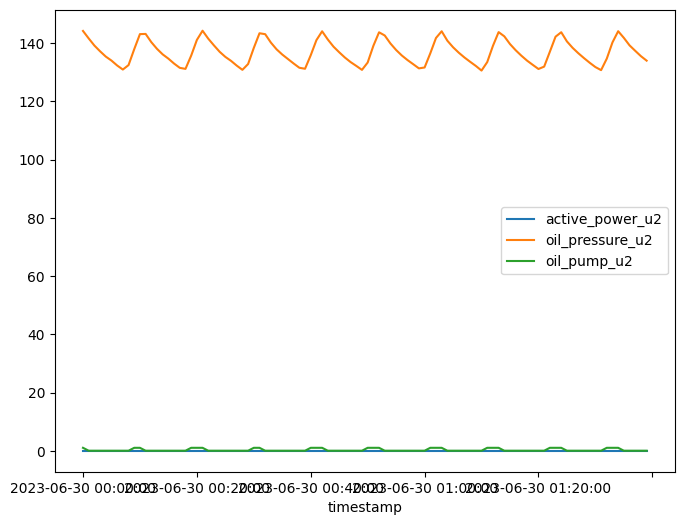

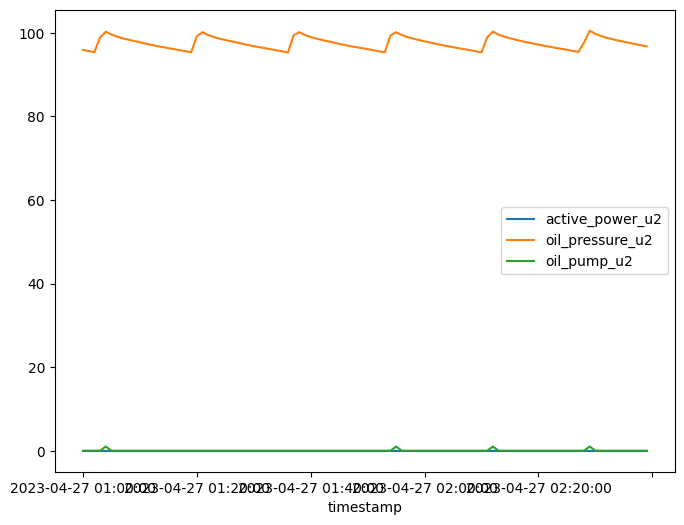

In [16]:
p1_u1_full.iloc[:120,:].plot(figsize=(8,6))
p1_u2_full.iloc[:100,:].plot(figsize=(8,6))
p1_u2_small.iloc[:100,:].plot(figsize=(8,6))
p2_u2_full.iloc[:100,:].plot(figsize=(8,6))

## Visualize peaks

In [17]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
def estimate_period_length(data, show=None):
    peaks, _ = find_peaks(data.values)

    if len(peaks) > 1:
        peak_distances = np.diff(peaks)
        period = np.mean(peak_distances)
    else:
        period = None
    
    peak_distances = [0 if d > 100 else d for d in peak_distances]
    if show == 'plt':
        fig, ax1 = plt.subplots(figsize=(24, 4))

        # Plot data and peaks on the primary y-axis
        ax1.plot(data, label='Data')
        ax1.plot(peaks, data.iloc[peaks], "x", label='Peaks')
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel('Value')
        ax1.set_title('Peak Detection')
        ax1.set_xticks(peaks)  # Set x-ticks to the peak indices
        ax1.set_xticklabels(data.index[peaks], rotation=90)

        # Create a secondary y-axis for peak distances
        ax2 = ax1.twinx()
        ax2.plot(peaks[1:], peak_distances, color='orange', label='Peak Distances')
        ax2.set_ylabel('Peak Distance')
        plt.ylim(0, 1.5 * period)  # Set the y-axis limits to the peak distance range

        # Show both legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()
        
    elif show == 'interact':
        # Create the figure
        fig = go.Figure()
        peak_distances = pd.Series(peak_distances).rolling(window=max(int(len(peak_distances)*0.01),1)).mean()
        # Plot the main data series on the primary y-axis
        fig.add_trace(go.Scatter(
            x=data.index,
            y=data,
            mode='lines',
            name='Data',
            line=dict(color='blue'),
            opacity=0.8  # Set opacity to 0.8
        ))

        # Highlight peaks on the primary y-axis with 80% opacity
        fig.add_trace(go.Scatter(
            x=[data.index[p] for p in peaks],
            y=[data.iloc[p] for p in peaks],
            mode='markers',
            marker=dict(color='red', size=8, symbol='x', opacity=0.5),  # Marker opacity set to 0.8
            name='Peaks'
        ))

        # Plot peak distances on the secondary y-axis with 80% opacity
        fig.add_trace(go.Scatter(
            x=[data.index[p] for p in peaks[1:]],  # x positions for peak distances
            y=peak_distances,
            mode='lines+markers',
            name='Peak Distances',
            yaxis='y2',
            line=dict(color='orange', dash='dash', width=2),
            marker=dict(opacity=0.8),  # Marker opacity for peak distances
            opacity=0.8  # Set line opacity to 0.8
        ))

        # Set up the layout with dual y-axes
        fig.update_layout(
            title="Peak Detection with Interactive Dual Y-Axis",
            xaxis=dict(title='Timestamp', tickangle=90),
            yaxis=dict(title='Value', side='left'),
            yaxis2=dict(title='Peak Distance', overlaying='y', side='right'),  # Secondary y-axis
            legend=dict(x=0.1, y=1.1, orientation="h"),
            template='plotly_white',
            # width=1200,
            height=600,
        )

        # Show the interactive plot
        fig.show()
    
    print(f"Average Period Length: {period:.2f}")
    return peak_distances, period


In [ ]:
estimate_period_length(df_p1.loc['2023-05-01 00:00:00':'2023-11-01 00:00:00',['oil_pressure_u1']].iloc[:,0], show='interact')
estimate_period_length(df_p1.loc['2023-05-01 00:00:00':'2023-11-01 00:00:00',['oil_pressure_u2']].iloc[:,0], show='interact')
estimate_period_length(df_p2.loc['2023-03-01 00:00:00':'2023-08-01 00:00:00',['oil_pressure_u1']].iloc[:,0], show='interact')
estimate_period_length(df_p2.loc['2023-03-01 00:00:00':'2023-08-01 00:00:00',['oil_pressure_u2']].iloc[:,0], show='interact')

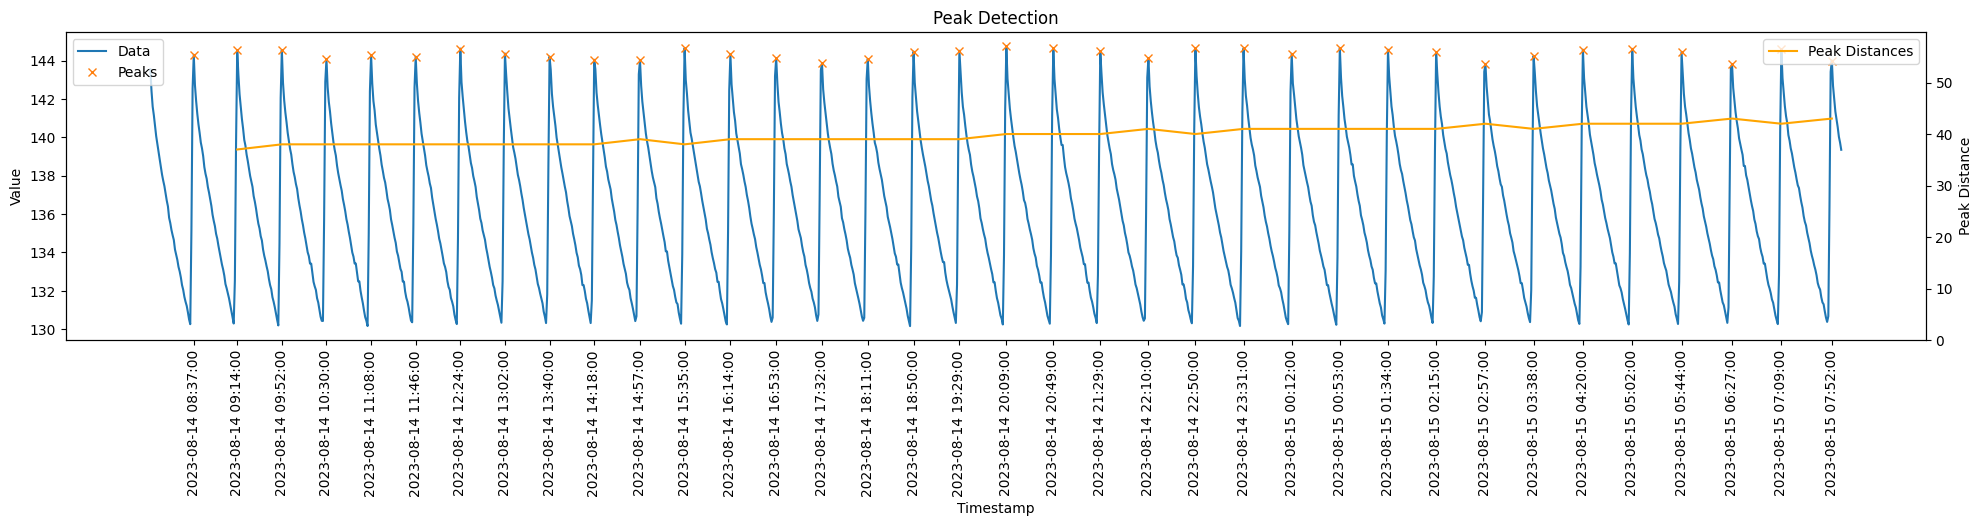

Average Period Length: 39.86


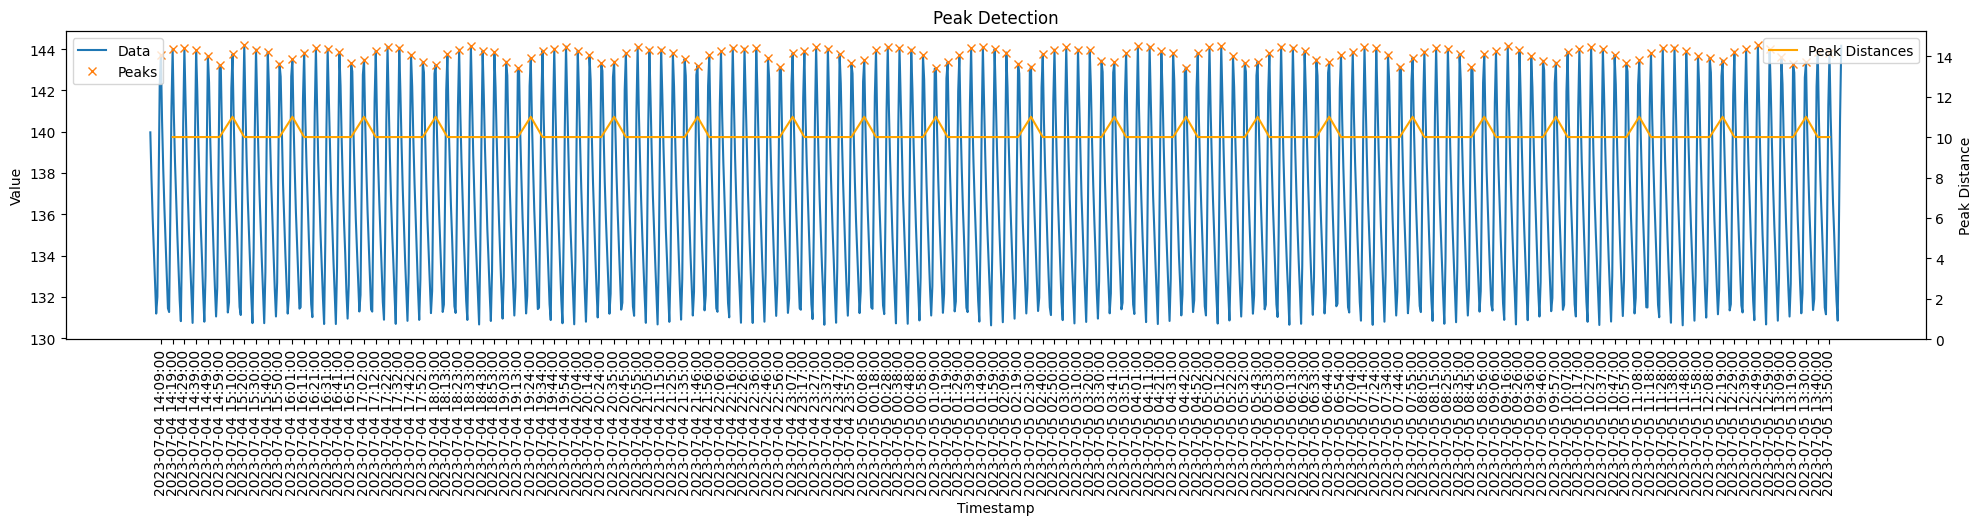

Average Period Length: 10.15


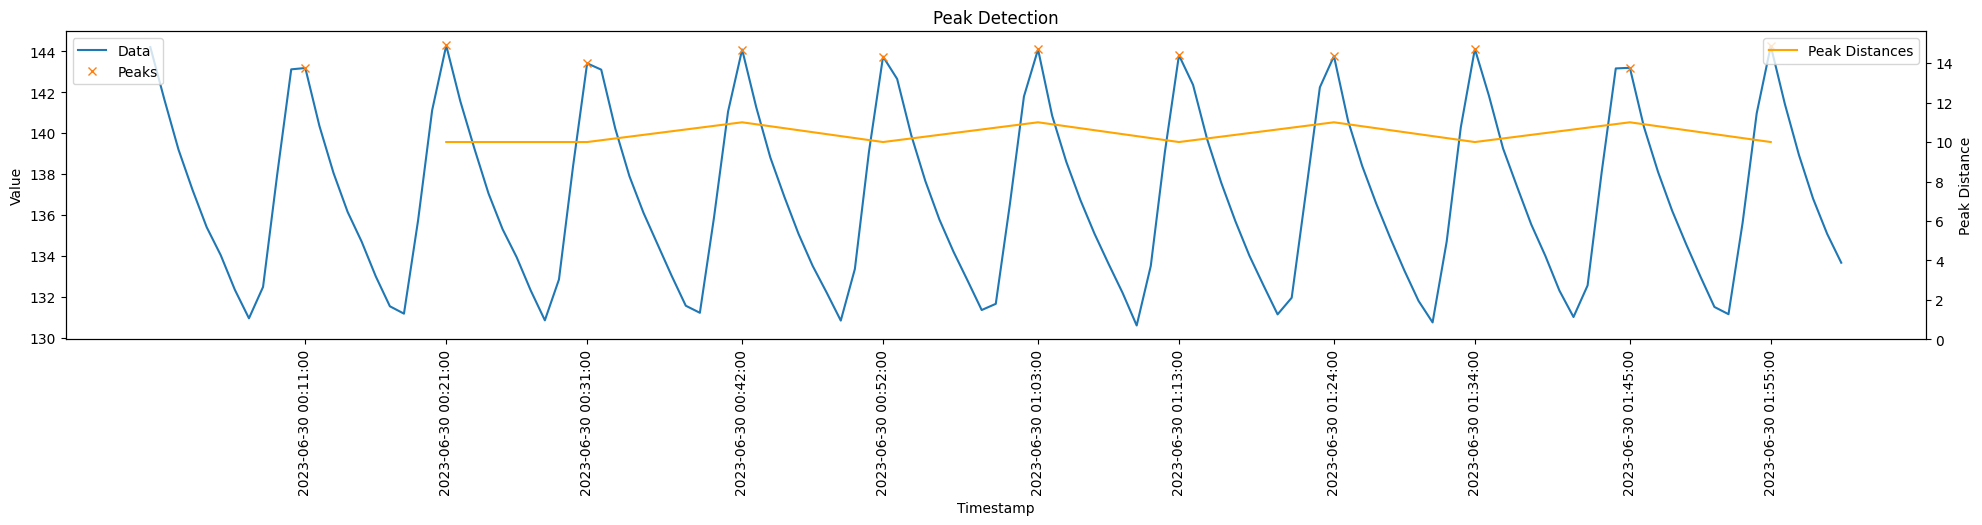

Average Period Length: 10.40


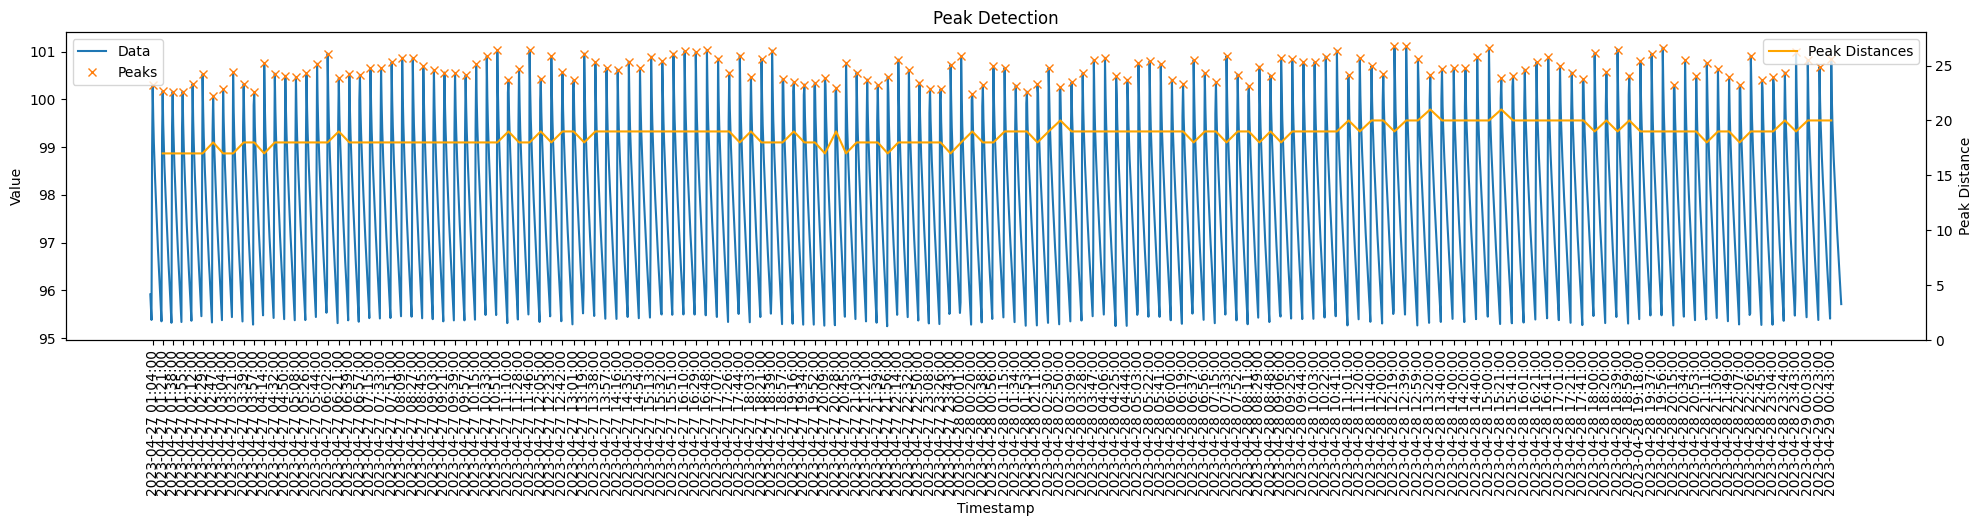

Average Period Length: 18.69


In [19]:
peak_distances_p1_u1_full, period_length_p1_u1_full = estimate_period_length(p1_u1_full.iloc[:,1], show='plt')
peak_distances_p1_u2_full, period_length_p1_u2_full = estimate_period_length(p1_u2_full.iloc[:,1], show='plt')
peak_distances_p1_u2_small, period_length_p1_u2_small = estimate_period_length(p1_u2_small.iloc[:,1], show='plt')
peak_distances_p2_u2_full, period_length_p2_u2_full = estimate_period_length(p2_u2_full.iloc[:,1], show='plt')

# Standardization

In [7]:
#standardization
# scaler = StandardScaler()
scaler = MinMaxScaler()
combined_data = np.vstack([df_p1.loc[:,['oil_pressure_u1']], df_p1.loc[:,['oil_pressure_u1']]])
scaler.fit_transform(combined_data)
# df_p1.iloc[:,[5]] = scaler.transform(df_p1.loc[:,[5]])
# df_p1.iloc[:,[1]] = scaler.transform(df_p1.iloc[:,[1]])
oil_pressure_columns = df_p1.columns[df_p1.columns.str.startswith('oil_pressure')].values

df_p1_scaled = df_p1.copy(deep=True)
for column in oil_pressure_columns:
    df_p1_scaled.loc[:, column] = scaler.transform(df_p1.loc[:, column].values.reshape(-1,1)).flatten()
df_p1_scaled = df_p1_scaled.drop(columns=['oil_pump1_u1', 'oil_pump2_u1','oil_pump1_u2','oil_pump2_u2'])
df_p1_scaled

,active_power_u1,oil_pressure_u1,active_power_u2,oil_pressure_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,
2023-02-01 00:00:00,20.700001,0.978726,22.900000,0.959099,1.0,1.0
2023-02-01 00:01:00,20.700001,0.977091,22.950000,0.959099,1.0,1.0
2023-02-01 00:02:00,20.700001,0.977073,22.900000,0.959146,1.0,1.0
2023-02-01 00:03:00,20.700001,0.977137,22.900000,0.958990,1.0,1.0
2023-02-01 00:04:00,20.700001,0.977491,22.950000,0.959136,1.0,1.0
...,...,...,...,...,...,...
2024-01-31 23:56:00,3.672727,0.916459,2.061765,0.905339,0.0,0.0
2024-01-31 23:57:00,3.672727,0.913794,2.061765,0.894004,0.0,0.0
2024-01-31 23:58:00,3.672727,0.912045,2.061765,0.884844,0.0,0.0


In [8]:
scaler_p2 = MinMaxScaler()
combined_data = np.vstack([df_p2.loc[:,['oil_pressure_u2']], df_p2.loc[:,['oil_pressure_u2']]])
scaler_p2.fit_transform(combined_data)
oil_pressure_columns = df_p2.columns[df_p2.columns.str.startswith('oil_pressure')].values

df_p2_scaled = df_p2.copy(deep=True)
for column in oil_pressure_columns:
    df_p2_scaled.loc[:, column] = scaler_p2.transform(df_p2.loc[:, column].values.reshape(-1,1)).flatten()
df_p2_scaled = df_p2_scaled.drop(columns=['oil_pump1_u1', 'oil_pump2_u1','oil_pump1_u2','oil_pump2_u2'])
df_p2_scaled

,active_power_u1,oil_pressure_u1,active_power_u2,oil_pressure_u2,oil_pump_u1,oil_pump_u2
timestamp,,,,,,
2023-02-01 00:00:00,37.169407,0.935942,10.479582,0.996648,1.0,1.0
2023-02-01 00:01:00,36.838044,0.935561,15.750134,0.992548,1.0,1.0
2023-02-01 00:02:00,36.696438,0.935560,16.463206,0.992222,1.0,1.0
2023-02-01 00:03:00,36.813082,0.935466,14.003401,0.992514,1.0,1.0
2023-02-01 00:04:00,37.037916,0.935638,14.661157,0.993425,1.0,1.0
...,...,...,...,...,...,...
2024-01-31 23:56:00,10.571480,0.910083,16.231666,0.995400,0.0,0.0
2024-01-31 23:57:00,10.571480,0.900190,15.154579,0.996173,0.0,0.0
2024-01-31 23:58:00,10.571480,0.905454,12.345287,0.995866,0.0,0.0


In [9]:
from datetime import datetime, timedelta
# filter the non-producing period after standardization
p1_u1_full = df_p1_scaled.iloc[:,[0,1,4]].loc[timespan_p1_u1_full[0]:timespan_p1_u1_full[1]]
p1_u1_full_val = df_p1_scaled.iloc[:,[0,1,4]].loc[(datetime.strptime(timespan_p1_u1_full[0], '%Y-%m-%d %H:%M:%S') - timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S'):timespan_p1_u1_full[0]]

p1_u2_full = df_p1_scaled.iloc[:,[2,3,5]].loc[timespan_p1_u2_full[0]:timespan_p1_u2_full[1]]
p1_u2_small = df_p1_scaled.iloc[:,[2,3,5]].loc[timespan_p1_u2_small[0]:timespan_p1_u2_small[1]]
p1_u2_val = df_p1_scaled.iloc[:,[2,3,5]].loc[(datetime.strptime(timespan_p1_u2_full[0], '%Y-%m-%d %H:%M:%S') - timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S'):timespan_p1_u2_full[0]]

p2_u2_full = df_p2_scaled.iloc[:,[2,3,5]].loc[timespan_p2_u2_full[0]:timespan_p2_u2_full[1]]
p2_u2_val = df_p2_scaled.iloc[:,[2,3,5]].loc[timespan_p2_u2_full[1]:(datetime.strptime(timespan_p2_u2_full[1], '%Y-%m-%d %H:%M:%S') + timedelta(hours=24)).strftime('%Y-%m-%d %H:%M:%S'):]

p1_u1_full.shape, p1_u1_full_val.shape, p1_u2_full.shape, p1_u2_small.shape, p1_u2_val.shape, p2_u2_full.shape, p2_u2_val.shape

((23041, 3), (1441, 3), (1441, 3), (121, 3), (1441, 3), (2881, 3), (1441, 3))

## Visualize scaled data

<Axes: xlabel='timestamp'>

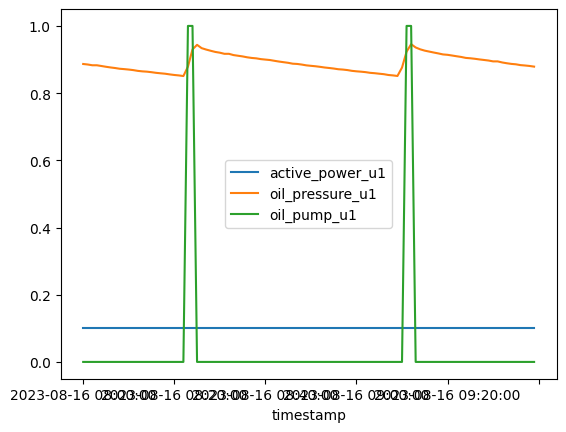

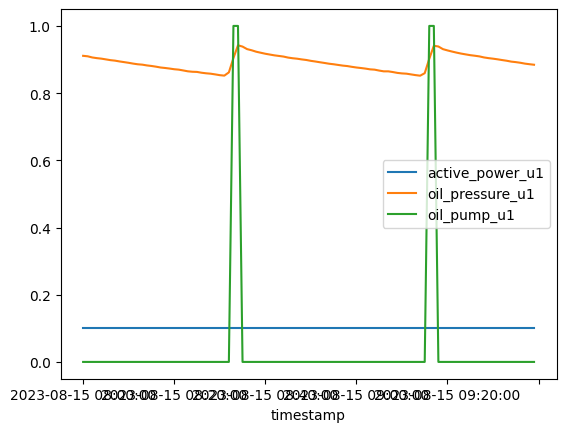

In [38]:
p1_u1_full.iloc[:100,:].plot()
p1_u1_full_val.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

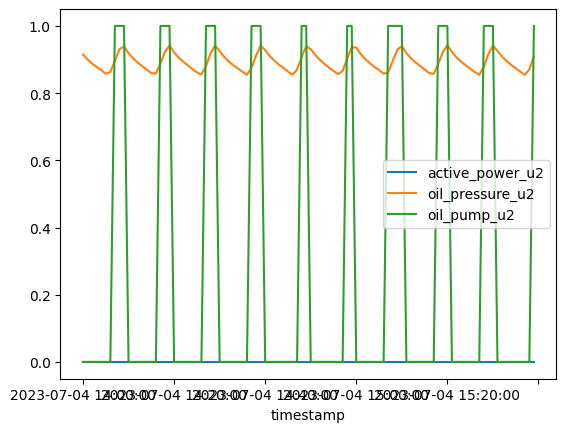

In [39]:
p1_u2_full.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

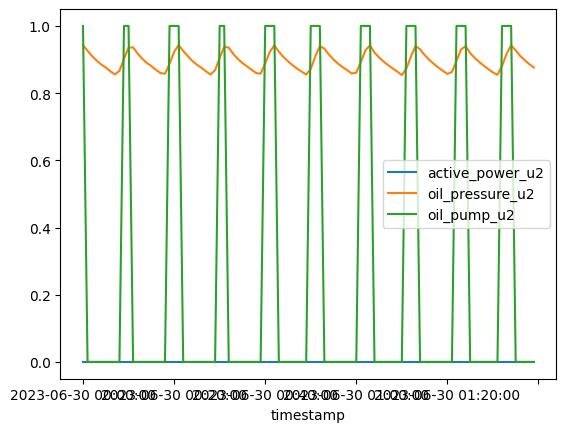

In [40]:
p1_u2_small.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

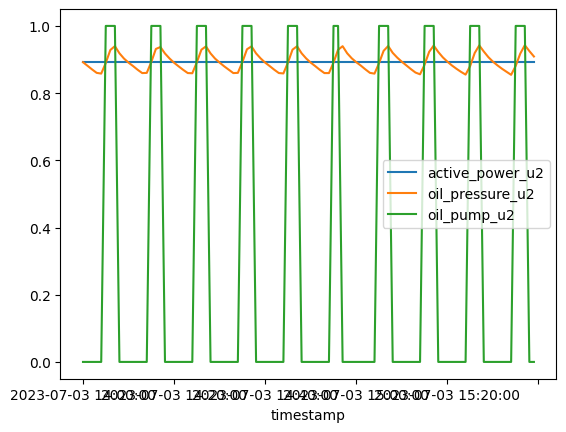

In [43]:
p1_u2_val.iloc[:100,:].plot()

<Axes: xlabel='timestamp'>

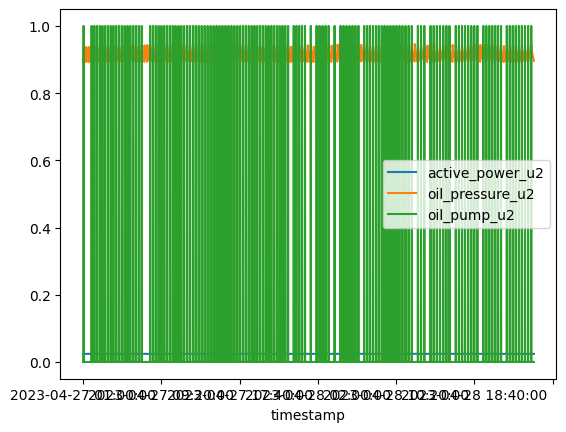

In [45]:
p2_u2_full.iloc[:,:].plot()

<Axes: xlabel='timestamp'>

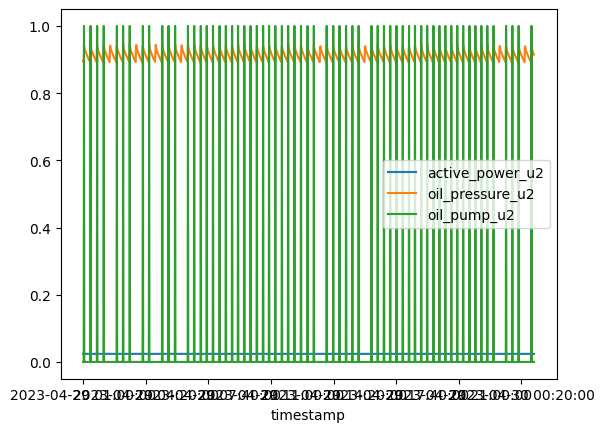

In [44]:
p2_u2_val.iloc[:,:].plot()

In [ ]:
# p1_u1_full = df_p1.iloc[:,:4].loc['2023-02-01 00:00:00 ':'2024-02-01 00:00:00']
# p1_u2_full = df_p1.iloc[:,4:].loc['2023-02-01 00:00:00 ':'2024-01-01 00:00:00']
# p1_u2_small = df_p1.iloc[:,4:].loc['2024-01-01 00:00:00':'2024-02-01 00:00:00']
# p1_u1_full.shape, p1_u2_full.shape, p1_u2_small.shape

# Training Preparation

In [11]:
#resample data for smaller datasets
def resample_data(df, new_frequency='1min'):
    # Ensure that the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Resample the data to the specified frequency, using the mean as the aggregation method
    resampled_df = df.resample(new_frequency).mean()
    
    return resampled_df


# p1_u1_full = resample_data(p1_u1_full)
# p1_u2_full = resample_data(p1_u2_full)
# p1_u2_small = resample_data(p1_u2_small)
# p1_u1_full.shape, p1_u2_full.shape, p1_u2_small.shape

In [10]:
def transform_data(X, sequence_length):
    # Convert the input dataframe to a tensor
    X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
    
    # Calculate the number of sequences that can be created
    num_samples = X_tensor.shape[0] - sequence_length + 1
    num_features = X_tensor.shape[1]
    
    # Create a view with sliding windows of size (sequence_length, num_features)
    X_sequences = torch.zeros((num_samples, sequence_length, num_features), dtype=torch.float32)
    for i in range(num_samples):
        X_sequences[i] = X_tensor[i:i + sequence_length]
    
    # Create a dataset
    dataset = TensorDataset(X_sequences)
    print(X_sequences.shape)
    return dataset



In [11]:
# Pretrain function
# gradscaler = GradScaler(init_scale=2.0)

#define different weights for each signal (active_power, oil_pressure, pump)
loss_weights = torch.tensor([0.1, 1.0, 1.0], dtype=torch.float32).to(device) 

def weighted_mse_loss(output, target, loss_weights):
    mse = (output - target) ** 2
    weighted_mse = mse * loss_weights  # Apply column-wise weights
    return weighted_mse.mean()

def pretrain(model, data, val_data, save_path, epochs=100, batch_size=64, learning_rate=1e-4, early_stop = True):  # Decreased learning rate for more stable training
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    
    # criterion = nn.SmoothL1Loss()  # Changed to Huber Loss for more robustness to outliers
    # criterion = nn.MSELoss()  # Changed to MSE Loss for better reconstruction
    
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
    
    best_loss = float('inf')
    patience = 1000  # Increased patience to allow more epochs before early stopping
    counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            output = model(batch)
            # loss = criterion(output, batch)
            loss = weighted_mse_loss(output, batch, loss_weights)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()            
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(dataloader)
        train_losses.append(epoch_loss)
        
        val_loss = 0      
        model.eval()
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch[0].to(device)
                val_output = model(val_batch)
                val_loss += weighted_mse_loss(val_output, val_batch, loss_weights).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Pretrain Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Total Loss: {total_loss}, Val Loss:{val_loss}")
        
        # scheduler.step(val_loss)
        
        # Early Stopping Check
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            
            # Save the model with the best performance
            torch.save(model.state_dict(), save_path)
            # print(f"New best model saved with loss {best_loss:.4f}")
        else:
            counter += 1
            if counter >= patience and early_stop:
                print("Early stopping")
                break
                
    model.load_state_dict(torch.load(save_path, weights_only=True))
    return train_losses, val_losses

# Fine-tune function
def finetune(model, data, val_data, save_path, epochs=100, batch_size=64, learning_rate=1e-4, train_last_layer_only=True):  # Decreased learning rate for fine-tuning
    if train_last_layer_only:
        for name, param in model.named_parameters():
            if 'encoder_lstm' in name:
                param.requires_grad = False
    return pretrain(model, data, val_data, save_path, epochs, batch_size, learning_rate)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# Hyperparameters

hidden_dim = 64
num_layers = 2
# dropout = 0.0

# Training

torch.Size([951, 50, 3])
torch.Size([51, 50, 3])
torch.Size([51, 50, 3])
torch.Size([51, 50, 3])
Pretrain Epoch 10/1000, Train Loss: 0.011844424903392792, Total Loss: 0.17766637355089188, Val Loss:0.015359072014689445
Pretrain Epoch 20/1000, Train Loss: 0.011567876736323039, Total Loss: 0.17351815104484558, Val Loss:0.014668062329292297
Pretrain Epoch 30/1000, Train Loss: 0.011429822072386742, Total Loss: 0.17144733108580112, Val Loss:0.014701753854751587
Pretrain Epoch 40/1000, Train Loss: 0.011419308992723623, Total Loss: 0.17128963489085436, Val Loss:0.014698049053549767
Pretrain Epoch 50/1000, Train Loss: 0.011388198100030422, Total Loss: 0.17082297150045633, Val Loss:0.01468065194785595
Pretrain Epoch 60/1000, Train Loss: 0.011320455248157184, Total Loss: 0.16980682872235775, Val Loss:0.01471142377704382
Pretrain Epoch 70/1000, Train Loss: 0.01125129529585441, Total Loss: 0.16876942943781614, Val Loss:0.014832748100161552
Pretrain Epoch 80/1000, Train Loss: 0.010852301244934399, T

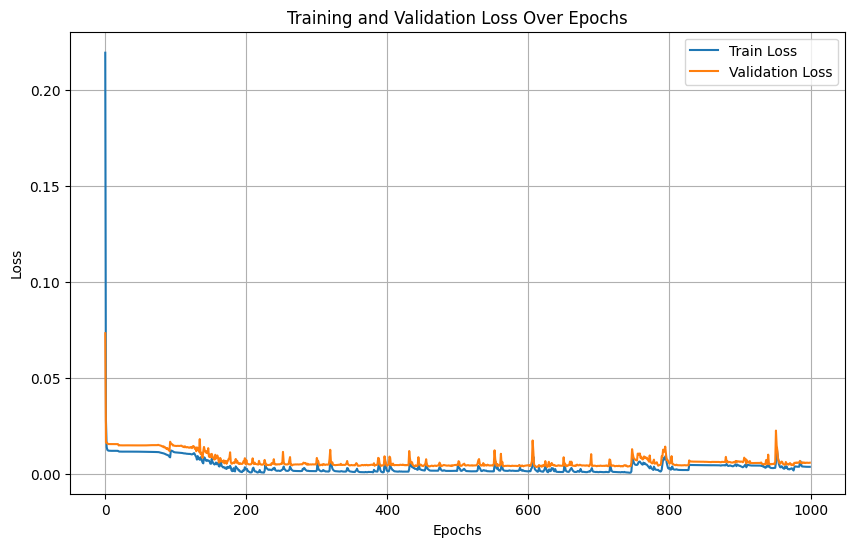

Pretrain Epoch 10/500, Train Loss: 0.0901799276471138, Total Loss: 0.0901799276471138, Val Loss:0.11862282454967499
Pretrain Epoch 20/500, Train Loss: 0.08382236212491989, Total Loss: 0.08382236212491989, Val Loss:0.11205922067165375
Pretrain Epoch 30/500, Train Loss: 0.07976464927196503, Total Loss: 0.07976464927196503, Val Loss:0.1077168732881546
Pretrain Epoch 40/500, Train Loss: 0.07793011516332626, Total Loss: 0.07793011516332626, Val Loss:0.10672802478075027
Pretrain Epoch 50/500, Train Loss: 0.07695695012807846, Total Loss: 0.07695695012807846, Val Loss:0.10684391111135483
Pretrain Epoch 60/500, Train Loss: 0.07619303464889526, Total Loss: 0.07619303464889526, Val Loss:0.1072276160120964
Pretrain Epoch 70/500, Train Loss: 0.07551438361406326, Total Loss: 0.07551438361406326, Val Loss:0.10730811208486557
Pretrain Epoch 80/500, Train Loss: 0.07501394301652908, Total Loss: 0.07501394301652908, Val Loss:0.10705921798944473
Pretrain Epoch 90/500, Train Loss: 0.07449851185083389, Tota

In [ ]:
# -------------------- Training with Transfer Learning: p1_u1_full -> p1_u2_small--------------------
torch.cuda.empty_cache()
import LSTMAutoencoder
importlib.reload(LSTMAutoencoder)
from LSTMAutoencoder import SimpleLSTMAutoencoder

sequence_length = 50
model_save_path="./models/lstm_TL_u1.pth"
source_dataset = transform_data(p1_u1_full.iloc[:1000,:], sequence_length)
source_val_dataset = transform_data(p1_u1_full_val.iloc[:100,:], sequence_length)
target_small_dataset = transform_data(p1_u2_small.iloc[:100,:], sequence_length)
target_val_dataset = transform_data(p1_u2_val.iloc[:100,:], sequence_length)

input_dim = [batch[0][1].shape for batch in source_dataset][0][0]

# Initialize LSTM Autoencoder
lstm_autoencoder_1 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Pretrain on p1_u1_full
train_losses, val_losses = pretrain(lstm_autoencoder_1, source_dataset, source_val_dataset, epochs=1000, learning_rate=1e-3, batch_size=64, save_path=model_save_path)
plot_losses(train_losses, val_losses)

# Fine-tune on p1_u2_small
finetune(lstm_autoencoder_1, target_small_dataset, target_val_dataset, epochs=500, train_last_layer_only=True, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_1, model_save_path)
print('model saved')

torch.Size([86, 15, 3])
torch.Size([86, 15, 3])
torch.Size([986, 15, 3])
Pretrain Epoch 10/500, Train Loss: 0.06476061721332371, Total Loss: 1.0361698754131794, Val Loss:0.09435597434639931
Pretrain Epoch 20/500, Train Loss: 0.060500629944726825, Total Loss: 0.9680100791156292, Val Loss:0.09762300178408623
Pretrain Epoch 30/500, Train Loss: 0.010277592635247856, Total Loss: 0.1644414821639657, Val Loss:0.04598075896501541
Pretrain Epoch 40/500, Train Loss: 0.0018434333433106076, Total Loss: 0.02949493349296972, Val Loss:0.05001392215490341
Pretrain Epoch 50/500, Train Loss: 0.0005500110073626274, Total Loss: 0.008800176117802039, Val Loss:0.04996000975370407
Pretrain Epoch 60/500, Train Loss: 0.0002249580766147119, Total Loss: 0.0035993292258353904, Val Loss:0.053506866097450256
Pretrain Epoch 70/500, Train Loss: 0.000138084987156617, Total Loss: 0.002209359794505872, Val Loss:0.060415344312787056
Pretrain Epoch 80/500, Train Loss: 0.00010296741584170377, Total Loss: 0.0016474786534672

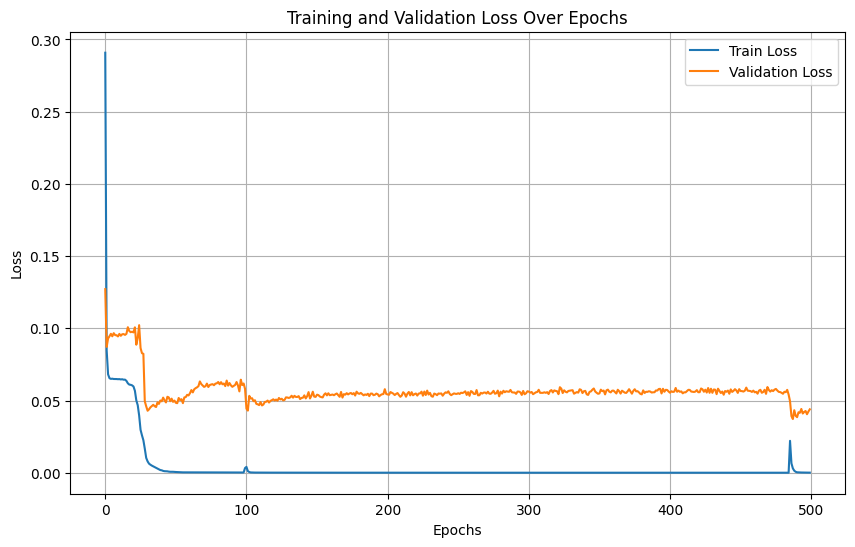

Pretrain Epoch 10/300, Train Loss: 0.0014958222163841128, Total Loss: 0.0029916444327682257, Val Loss:0.03988979756832123
Pretrain Epoch 20/300, Train Loss: 0.0012149011017754674, Total Loss: 0.002429802203550935, Val Loss:0.03937540762126446
Pretrain Epoch 30/300, Train Loss: 0.0009957953006960452, Total Loss: 0.0019915906013920903, Val Loss:0.039210984483361244
Pretrain Epoch 40/300, Train Loss: 0.0008831014565657824, Total Loss: 0.0017662029131315649, Val Loss:0.03824038431048393
Pretrain Epoch 50/300, Train Loss: 0.0006821954739280045, Total Loss: 0.001364390947856009, Val Loss:0.03911617584526539
Pretrain Epoch 60/300, Train Loss: 0.0006192006694618613, Total Loss: 0.0012384013389237225, Val Loss:0.03881515935063362
Pretrain Epoch 70/300, Train Loss: 0.0004307737690396607, Total Loss: 0.0008615475380793214, Val Loss:0.040941428393125534
Pretrain Epoch 80/300, Train Loss: 0.00034398982825223356, Total Loss: 0.0006879796565044671, Val Loss:0.03974016383290291
Pretrain Epoch 90/300, 

In [21]:
# -------------------- Training on Full Target Data: p1_u2_full -> p1_u2_small --------------------

# Initialize LSTM Autoencoder
sequence_length = 15
model_save_path="./models/lstm_TL_u2.pth"

target_small_dataset = transform_data(p1_u2_small.iloc[:100,:], sequence_length)
target_val_dataset = transform_data(p1_u2_val.iloc[:100,:], sequence_length)
target_full_dataset = transform_data(p1_u2_full.iloc[:1000,:], sequence_length)

# lstm_autoencoder_2 = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)
lstm_autoencoder_2 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Pretrain on p1_u2_full
train_losses, val_losses = pretrain(lstm_autoencoder_2, target_full_dataset, target_val_dataset, epochs=500, learning_rate=1e-3, batch_size=64, save_path=model_save_path)
plot_losses(train_losses, val_losses)

# Fine-tune on p1_u2_small
finetune(lstm_autoencoder_2, target_small_dataset, target_val_dataset, epochs=300, train_last_layer_only=True, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_2, model_save_path)
print('model saved')

Pretrain Epoch 10/200, Train Loss: 0.10816380754113197, Total Loss: 0.21632761508226395, Val Loss:0.1250452660024166
Pretrain Epoch 20/200, Train Loss: 0.06748271360993385, Total Loss: 0.1349654272198677, Val Loss:0.09009509533643723
Pretrain Epoch 30/200, Train Loss: 0.0668412446975708, Total Loss: 0.1336824893951416, Val Loss:0.09449945762753487
Pretrain Epoch 40/200, Train Loss: 0.06546885520219803, Total Loss: 0.13093771040439606, Val Loss:0.0955120213329792
Pretrain Epoch 50/200, Train Loss: 0.06640997901558876, Total Loss: 0.13281995803117752, Val Loss:0.09614010527729988
Pretrain Epoch 60/200, Train Loss: 0.06543322652578354, Total Loss: 0.13086645305156708, Val Loss:0.09353627637028694
Pretrain Epoch 70/200, Train Loss: 0.06607689335942268, Total Loss: 0.13215378671884537, Val Loss:0.09527241438627243
Pretrain Epoch 80/200, Train Loss: 0.06455021724104881, Total Loss: 0.12910043448209763, Val Loss:0.09504562616348267
Pretrain Epoch 90/200, Train Loss: 0.06364110857248306, Total

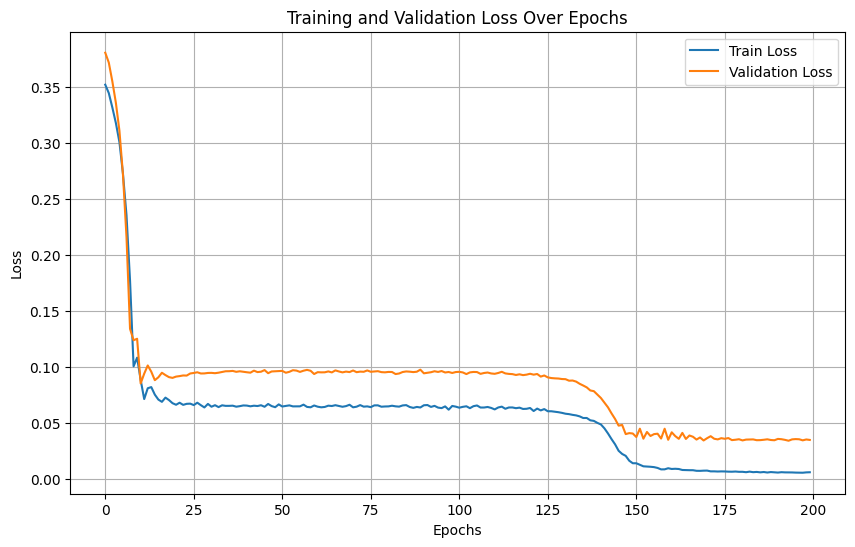

model saved


In [22]:
# -------------------- Training without Transfer Learning: p1_u2_small only--------------------

# Initialize LSTM Autoencoder
sequence_length = 15
model_save_path="./models/lstm_small.pth"
lstm_autoencoder_3 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Train directly on p1_u2_small without pretraining
train_losses, val_losses = pretrain(lstm_autoencoder_3, target_small_dataset, target_val_dataset, epochs=200, learning_rate=1e-3, batch_size=64, save_path=model_save_path)
plot_losses(train_losses, val_losses)

# Save model
torch.save(lstm_autoencoder_3, model_save_path)
print('model saved')

torch.Size([979, 22, 3])
torch.Size([79, 22, 3])
torch.Size([79, 22, 3])
torch.Size([79, 22, 3])
Pretrain Epoch 10/1000, Train Loss: 0.016749508504290134, Total Loss: 0.26799213606864214, Val Loss:0.013287544716149569
Pretrain Epoch 20/1000, Train Loss: 0.016627189586870372, Total Loss: 0.26603503338992596, Val Loss:0.01324104843661189
Pretrain Epoch 30/1000, Train Loss: 0.01658241864060983, Total Loss: 0.2653186982497573, Val Loss:0.013225148431956768
Pretrain Epoch 40/1000, Train Loss: 0.016538579657208174, Total Loss: 0.2646172745153308, Val Loss:0.011943941470235586
Pretrain Epoch 50/1000, Train Loss: 0.0159191673155874, Total Loss: 0.2547066770493984, Val Loss:0.013151878956705332
Pretrain Epoch 60/1000, Train Loss: 0.002772333493339829, Total Loss: 0.044357335893437266, Val Loss:0.004174958914518356
Pretrain Epoch 70/1000, Train Loss: 0.0007516437672165921, Total Loss: 0.012026300275465474, Val Loss:0.0033757148194126785
Pretrain Epoch 80/1000, Train Loss: 0.0003816902471953654, 

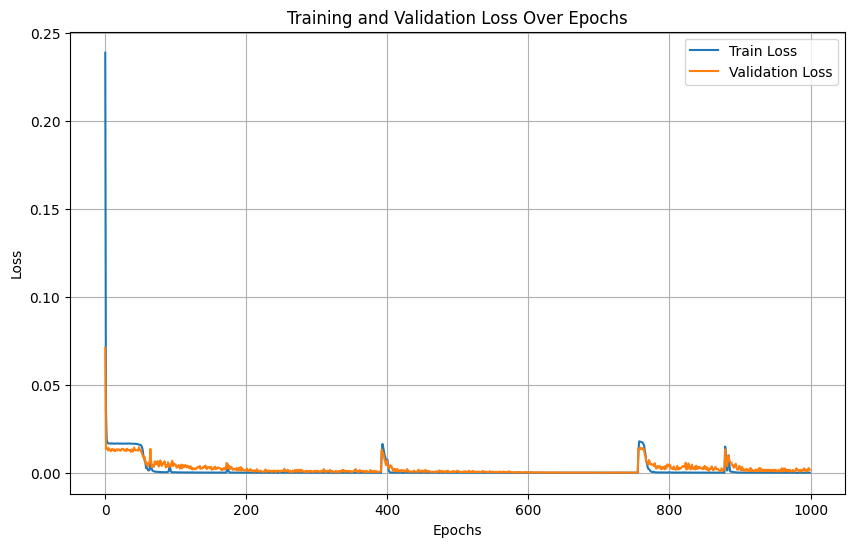

Pretrain Epoch 10/500, Train Loss: 0.06538935005664825, Total Loss: 0.1307787001132965, Val Loss:0.10644951835274696
Pretrain Epoch 20/500, Train Loss: 0.06130303256213665, Total Loss: 0.1226060651242733, Val Loss:0.09994669258594513
Pretrain Epoch 30/500, Train Loss: 0.056795768439769745, Total Loss: 0.11359153687953949, Val Loss:0.10167050361633301
Pretrain Epoch 40/500, Train Loss: 0.049307577311992645, Total Loss: 0.09861515462398529, Val Loss:0.0922485701739788
Pretrain Epoch 50/500, Train Loss: 0.045257747173309326, Total Loss: 0.09051549434661865, Val Loss:0.09707041829824448
Pretrain Epoch 60/500, Train Loss: 0.04373600892722607, Total Loss: 0.08747201785445213, Val Loss:0.09431663900613785
Pretrain Epoch 70/500, Train Loss: 0.0405743345618248, Total Loss: 0.0811486691236496, Val Loss:0.08883998170495033
Pretrain Epoch 80/500, Train Loss: 0.04092276468873024, Total Loss: 0.08184552937746048, Val Loss:0.09131939709186554
Pretrain Epoch 90/500, Train Loss: 0.03589105233550072, To

In [16]:
# -------------------- Transfer Learning: from p2_u2 to p1_u2--------------------
sequence_length = 22
model_save_path="./models/lstm_TL_p2.pth"
source_dataset = transform_data(p2_u2_full[200:1200], sequence_length)
source_val_dataset = transform_data(p2_u2_val[:100], sequence_length)
target_small_dataset = transform_data(p1_u2_small[:100], sequence_length)
target_val_dataset = transform_data(p1_u2_val[:100], sequence_length)

input_dim = [batch[0][1].shape for batch in source_dataset][0][0]

# Initialize LSTM Autoencoder
lstm_autoencoder_4 = SimpleLSTMAutoencoder(input_dim, hidden_dim, sequence_length, num_layers).to(device)

# Pretrain on p2_u2_full
train_losses, val_losses = pretrain(lstm_autoencoder_4, source_dataset, source_val_dataset, epochs=1000, learning_rate=1e-3, batch_size=64, save_path=model_save_path, early_stop=False)
plot_losses(train_losses, val_losses)

# Fine-tune on p1_u2_small
finetune(lstm_autoencoder_4, target_small_dataset, target_val_dataset, epochs=500, train_last_layer_only=True, save_path=model_save_path)

# Save model
torch.save(lstm_autoencoder_4, model_save_path)
print('model saved')

# Generate Anomaly Scores

In [13]:
import importlib
import generate_anomaly_score
importlib.reload(generate_anomaly_score)
from generate_anomaly_score import process_and_save_anomaly_scores

# load test data
root_dir = './data'

data_files = ['inter_leakage.csv', 'pump_failure.csv']
# data_files = ['test_p2_u2.csv']

# Run the anomaly detection and save results
model_files = ['./models/lstm_TL_u1.pth']
data_with_anomaly_scores = process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler, sequence_length=50)

# model_files = ['./models/lstm_small_v1.pth', './models/lstm_TL_u2_v1.pth']
# data_with_anomaly_scores = process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler, sequence_length=15)

# model_files = ['./models/lstm_TL_p2.pth']
# data_with_anomaly_scores = process_and_save_anomaly_scores(data_files, model_files, root_dir, scaler_p2, sequence_length=22)

Anomaly scores saved to ./results/inter_leakage_lstm_TL_u1_scored.csv
Anomaly scores saved to ./results/pump_failure_lstm_TL_u1_scored.csv


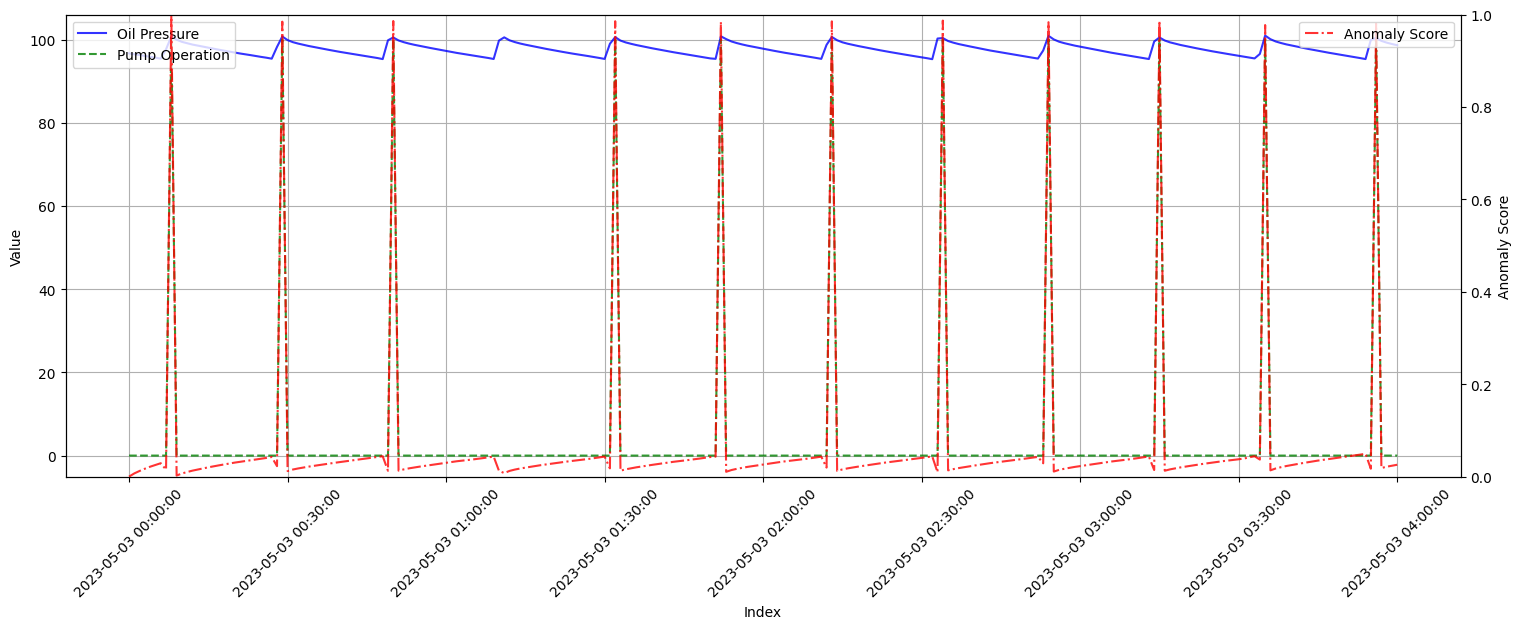

In [43]:
# data = pd.read_csv('./results/test_u1_lstm_TL_u1_scored.csv', index_col='timestamp')[:500]
# data = data_with_anomaly_scores[:500]

def plot_test_training(data):
    fig, ax1 = plt.subplots(figsize=(18, 6))
    # Plot Oil Pressure and Pump Operation on the left y-axis
    ax1.plot(data.index, data.iloc[:,1], label='Oil Pressure', color='b', alpha=0.8)
    ax1.plot(data.index, data.iloc[:,2].apply(lambda x: 100 if x == 1 else x), label='Pump Operation', color='g', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Value')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    plt.xticks(data.index[::30], rotation=45)

    # Plot Anomaly Score on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['anomaly_score'], label='Anomaly Score', color='r', linestyle='-.', alpha=0.8)
    ax2.set_ylabel('Anomaly Score')
    ax2.legend(loc='upper right')
    plt.ylim(0,1)

    plt.show()
    
plot_test_training(pd.read_csv('./results/test_p2_u2_lstm_TL_p2_scored.csv', index_col='timestamp')[:500])
# plot_test_training(pd.read_csv('./results/test_u2_lstm_TL_u1_scored.csv', index_col='timestamp')[:500])

In [45]:
#visualize some reconstruction results of training data
for idx, batch in enumerate(target_full_dataset):
    if idx % sequence_length == 0:
        lstm_autoencoder_2.eval()
        with torch.no_grad():
            batch = batch[0].to(device).reshape(1,sequence_length,input_dim)
            output = lstm_autoencoder_2(batch).cpu().numpy()
            array1 = batch[0].cpu().numpy()[:,[1,2]]
            array2 = output[:,:,[1,2]][0]
            # print("in", array1, '\n out', array2)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            axes[0].plot(array1[:, 0], label='input - Oil Pressure', marker='o')
            axes[0].plot(array2[:, 0], label='output - Oil Pressure', marker='x')
            axes[0].set_title('Comparison of Column 1')
            axes[0].set_xlabel('Index')
            axes[0].set_ylabel('Value')
            axes[0].legend()

            # Plot for the second column
            axes[1].plot(array1[:, 1], label='input - Pump Operation', marker='o')
            axes[1].plot(array2[:, 1], label='output - Pump Operation', marker='x')
            axes[1].set_title('Comparison of Column 2')
            axes[1].set_xlabel('Index')
            axes[1].set_ylabel('Value')
            axes[1].legend()
            plt.ylim(-1.5,1.5)

            plt.tight_layout()
            plt.show()

            if idx > 3 * sequence_length:
                break

NameError: name 'target_full_dataset' is not defined